In [1]:
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt

## Functions

In [153]:


# @dataclass
# class Asset():
#     values:''
#     index:''
#     name:''
    

@dataclass(repr=False)
class Portfolio():
    data: pd.DataFrame #= field(default_factory=list) # anualized expected return
    weights: np.ndarray = None # 
    cov: np.ndarray = None

    def __post_init__(self):
        self.n_assets = data.shape[1]

    def get_equal_weights(self):
        return np.full(self.n_assets, fill_value=1/self.n_assets)

    def calc_port_return(self):
        return self.data @ self.get_

    def calc_prot_vol(self):
        return

def get_equal_weights(x):
    n_assets = x.shape[1]
    return np.full(n_assets, fill_value=1/n_assets)

def sharpe(port_ret, port_vol, risk_free_rate):
    return (port_ret-risk_free_rate)/port_vol

def get_port_returns(r, w):
    return r @ w

def get_port_vol(cov, w):
    return np.sqrt(w @ cov @ w)

def convert_returns(x, periods=252):
    return np.power(1+x, periods) - 1

def compound_returns(x, base=1):
    return (1+x).cumprod() * base

def period_return(x):
    return (1+x).prod() - 1




## Generating data

[[ 0.00505  0.001    0.     ]
 [ 0.001    0.02005 -0.0015 ]
 [ 0.      -0.0015   0.045  ]]
x0           0.067993
x1           0.137942
x2           0.218023
portfolio    0.092114
dtype: float64


<AxesSubplot:>

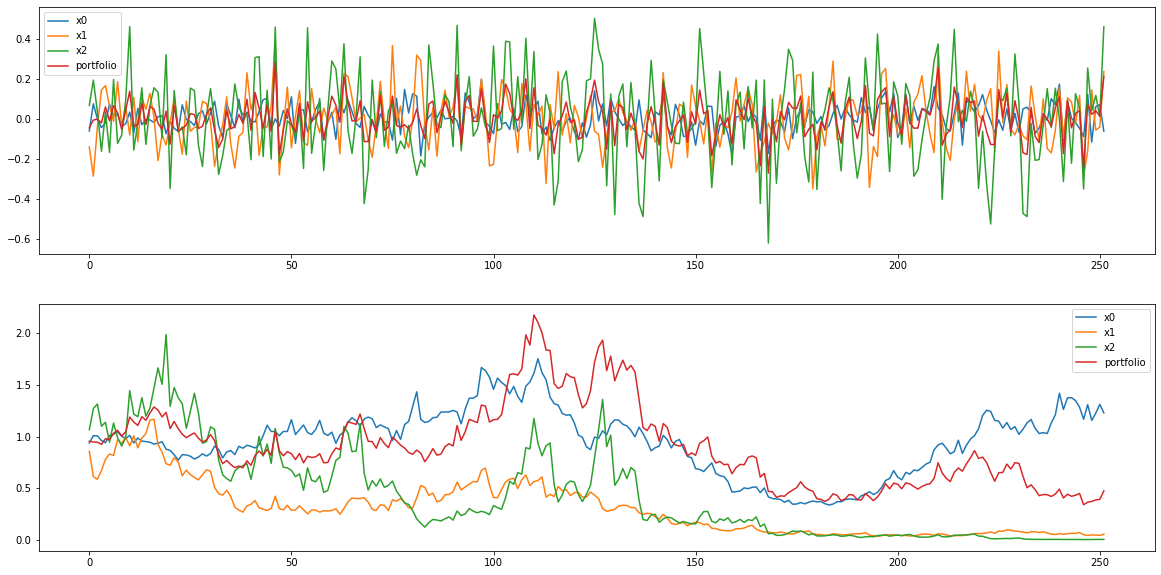

In [154]:

n_samples = 252

mean = [0.001, 0.005, 0.01]

A = np.array([
    [0.10, 0.00, 0.00], 
    [0.01, 0.20, 0.00],
    [0.00, -0.01, 0.30]
])
cov = np.matmul(A.T, A)/2
print(cov)

rng = np.random.default_rng(42)
data = pd.DataFrame(rng.multivariate_normal(mean, cov, size=n_samples)).rename(columns=lambda x: f'x{x}')

w = get_equal_weights(data)
r = get_port_returns(data, w)
r.std(), get_port_vol(data.cov(), w), get_port_vol(cov, w)


new = pd.concat([data, r.rename('portfolio')], axis=1)

print(new.std())



fig, axs = plt.subplots(nrows=2,figsize=(20,10))
axs=axs.flatten()
new.plot(ax=axs[0])
#(1+new).cumprod().plot(ax=axs[1])
compound_returns(new).plot(ax=axs[1])


## My portfolio

In [101]:
fmov = "b3-movimentacao-2020.xlsx"
dfmov_raw = pd.read_excel(fmov, na_values='-')

In [102]:
fix_columns = lambda x: (
    x.str.normalize('NFKD')
    .str.encode('ascii', 'ignore')
    .str.decode('utf8')
    .str.replace("\/|\(|R\$|\)|\.|,|\+|\:"," ", regex=True)
    .str.strip()
    .str.replace('\s+','_', regex=True)
    .str.lower()
)

fix_float = lambda x: x.str.replace('.','', regex=False).str.replace(',','.', regex=False).astype('float64')


dfmov = dfmov_raw.copy()
dfmov.columns = fix_columns(dfmov.columns)


dfmov = dfmov[dfmov.movimentacao=='Transferência - Liquidação'].copy()

dfmov['data'] = pd.to_datetime(dfmov.data, dayfirst=True)
dfmov['quantidade'] = fix_float(dfmov['quantidade'])

dfmov['ticker'] = dfmov.produto.str.split('-',1).str[0].str.strip()+'.SA'
dfmov['sinal'] = 0 + (dfmov.entrada_saida=='Credito') - (dfmov.entrada_saida=='Debito')
dfmov['quantidade'] = dfmov.sinal * dfmov.quantidade

dfmov = dfmov[['ticker', 'data', 'quantidade', 'preco_unitario']].reset_index(drop=True).sort_values(['ticker','data'])

In [174]:

def calc_preco_medio_por_ativo(x, qnt='quantidade', pu='preco_unitario'):
    x = x.copy()

    # quantidades ao longo do tempo
    x['qnt_acum'] = x[qnt].cumsum()

    x['valor_total_operacao'] = x[qnt] * x[pu]
    
    # soma das compras por ativo
    compra = lambda x: x>0
    x['valor_acum_compra'] = x['valor_total_operacao'].where(compra, 0).cumsum()
    x['qnt_acum_compra'] = x[qnt].where(compra, 0).cumsum()
    x['preco_medio_compra'] = x['valor_acum_compra'] / x['qnt_acum_compra'].replace(0, np.nan)
    
    return x

dfmov2 = dfmov.groupby('ticker', sort=False).apply(calc_preco_medio_por_ativo)

dfmov2 = dfmov2.replace('VVAR3.SA', 'VIIA3.SA')

In [300]:
dt_start = dfmov2.data.min()
dt_end = pd.Timestamp.today().normalize()
print(dt_start.date(), dt_end.date())

tickers = dfmov2['ticker'].drop_duplicates().tolist()

df_prices = web.DataReader(tickers, 'yahoo', start=dt_start, end=dt_end)['Adj Close']
print(df_prices.shape)
df_prices.head()

2020-03-12 2022-03-27


Symbols,ABEV3.SA,AZUL4.SA,CSNA3.SA,GOLL4.SA,IRBR3.SA,ITUB4.SA,OIBR3.SA,PETR3.SA,PETR4.SA,VIIA3.SA
Date,,,,,,,,,,
2020-03-12,10.806452,20.299999,6.253384,9.97,8.081381,22.487700,0.77,10.153106,10.240420,8.50
2020-03-13,11.851635,24.709999,7.555380,11.17,8.832109,24.974678,0.80,12.463490,12.516068,9.71
2020-03-16,10.293192,15.600000,6.842609,8.04,7.728096,22.678263,0.71,10.318134,10.638659,7.56
2020-03-17,10.909102,15.230000,7.365308,7.78,7.816418,24.012285,0.69,10.278842,10.565513,7.04
2020-03-18,10.442503,10.350000,6.376931,5.60,6.359119,22.344763,0.55,8.683579,9.175741,4.82


In [149]:
# stock daily returns
df_rets = df_prices.pct_change()

In [302]:
# real portfolio weights through time 
df_positions = dfmov2.set_index(['ticker','data']).qnt_acum.unstack('ticker').reindex_like(df_rets).ffill().fillna(0)
df_weights = df_positions.div(df_positions.sum(axis=1).replace(0, np.nan), axis=0)


In [303]:
# portfolio returns
port_ret = (df_rets * df_weights).sum(axis=1).rename('Portfolio')
df_ret_acum = compound_returns(df_rets.replace(np.nan, 0))
df_ret_port_acum = compound_returns(port_ret.replace(np.nan, 0))

<AxesSubplot:xlabel='Date'>

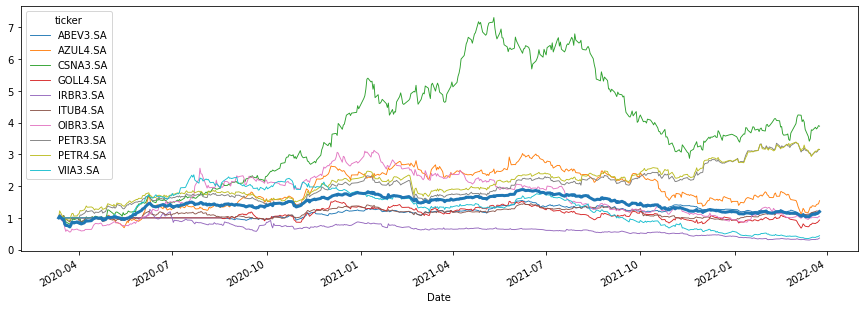

In [304]:
# plot stocks and portfolio cumulative returns
ax = df_ret_acum.plot(linewidth=0.9, figsize=(15,5))
df_ret_port_acum.plot(ax=ax, linewidth=3)

In [232]:
df_retall = pd.concat([df_rets, port_ret], axis=1)
#df_retall = pd.concat([df_ret_acum, df_ret_port_acum], axis=1)
dfcorr = df_retall.corr()

dfcorr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,ABEV3.SA,AZUL4.SA,CSNA3.SA,GOLL4.SA,IRBR3.SA,ITUB4.SA,OIBR3.SA,PETR3.SA,PETR4.SA,VIIA3.SA,Portfolio
ABEV3.SA,1.000000,0.375693,0.147377,0.392535,0.237278,0.490938,0.218799,0.376980,0.386278,0.311333,0.627318
AZUL4.SA,0.375693,1.000000,0.272136,0.883842,0.263268,0.435058,0.262550,0.418832,0.425419,0.350167,0.633488
CSNA3.SA,0.147377,0.272136,1.000000,0.200171,0.135390,0.393696,0.223297,0.347106,0.360306,0.163342,0.516784
GOLL4.SA,0.392535,0.883842,0.200171,1.000000,0.296542,0.410343,0.392161,0.374347,0.390638,0.434491,0.698132
IRBR3.SA,0.237278,0.263268,0.135390,0.296542,1.000000,0.294244,0.179924,0.236882,0.233986,0.258498,0.653880
ITUB4.SA,0.490938,0.435058,0.393696,0.410343,0.294244,1.000000,0.311045,0.560378,0.584678,0.260703,0.736880
OIBR3.SA,0.218799,0.262550,0.223297,0.392161,0.179924,0.311045,1.000000,0.228379,0.276588,0.292655,0.504561
PETR3.SA,0.376980,0.418832,0.347106,0.374347,0.236882,0.560378,0.228379,1.000000,0.970264,0.241088,0.580973
PETR4.SA,0.386278,0.425419,0.360306,0.390638,0.233986,0.584678,0.276588,0.970264,1.000000,0.266162,0.616613
VIIA3.SA,0.311333,0.350167,0.163342,0.434491,0.258498,0.260703,0.292655,0.241088,0.266162,1.000000,0.671505


In [251]:
from edhec_risk_kit_206 import plot_ef, annualize_rets

In [256]:
er = annualize_rets(df_rets,252)

cov = df_rets.cov()


## Hierarquical Risk Parity

In [305]:
from pypfopt import HRPOpt
hrp = HRPOpt(df_rets)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('ABEV3.SA', 0.2731),
             ('AZUL4.SA', 0.05008),
             ('CSNA3.SA', 0.09638),
             ('GOLL4.SA', 0.07745),
             ('IRBR3.SA', 0.10346),
             ('ITUB4.SA', 0.13212),
             ('OIBR3.SA', 0.07605),
             ('PETR3.SA', 0.0641),
             ('PETR4.SA', 0.04953),
             ('VIIA3.SA', 0.07772)])

<AxesSubplot:>

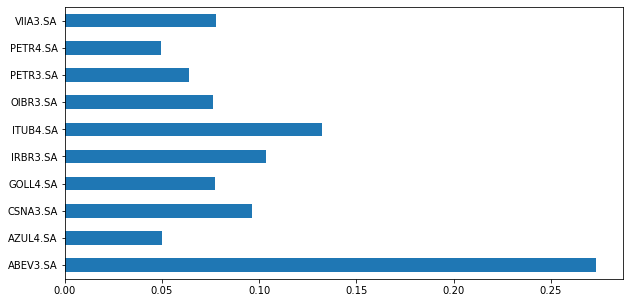

In [306]:
pd.Series(weights).plot.barh(figsize=(10, 5))

In [ ]:
every month:
    look back 6m
    calculate new weights
    rebalance
    
